# Cleaning and Analysing Data

Dans cette partie, on analyse et nettoie les données avant de ne leur appliquer des algo de machine learning

In [268]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import learning_curve
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cross_validation import train_test_split, cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset description

### Loading Data

In [2]:
path = 'CrowdstormingDataJuly1st.csv'
raw_data  = pd.read_csv(path)
print(raw_data .shape)
raw_data .head(5)

(146028, 28)


,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


146028 lignes (interaction joueur / arbitre), 28 features

In [3]:
raw_data[['playerShort', 'refNum']].duplicated().value_counts()

False    146028
dtype: int64

### Skin rating

- rater1 - skin rating of photo by rater 1 (5-point scale ranging from “very light skin” to “very dark skin”)
- rater2 - skin rating of photo by rater 2 (5-point scale ranging from “very light skin” to “very dark skin”)

In [4]:
np.sort(raw_data['rater1'].unique()), np.sort(raw_data['rater2'].unique())

(array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,   nan]),
 array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,   nan]))

Remove entries with both skin tone rating not available<br>
Ce sera notre dataset de base

In [4]:
df = raw_data.dropna(how='all', subset=['rater1', 'rater2'])
df.shape

(124621, 28)

Les notes sont-elles fiables?

In [68]:
np.abs(df['rater2'] - df['rater1']).describe()

count    124621.000000
mean          0.058319
std           0.106505
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.500000
dtype: float64

In [7]:
df.loc[np.abs(df['rater2'] - df['rater1']) == 0.5].shape[0]

164

In [5]:
index_unreliable = df.loc[np.abs(df['rater2'] - df['rater1']) == 0.5].index
df = df.drop(index_unreliable)
df.shape

(124457, 28)

In [6]:
df['skin'] = df[['rater1', 'rater2']].mean(axis=1)

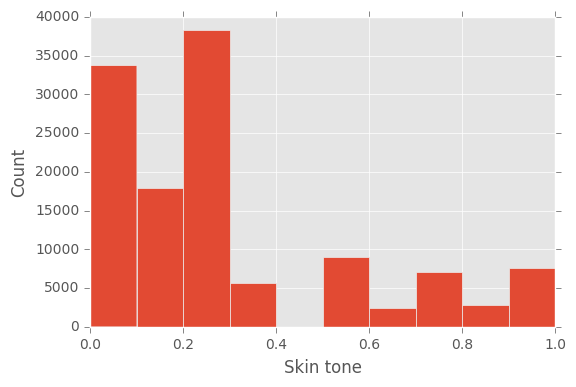

In [10]:
plt.hist(df.skin)
plt.xlabel("Skin tone") 
plt.ylabel("Count")

- Plus de blancs que de noirs (mais il vaut mieux regarder dans le df player pr se faire une idée de la pop)
- Quand on voit ça, on se dit qu'on peut faire 2 classes

In [7]:
# round x to their nearest n_val values
def discretize_by_width (x, nb_values): # x appartient à 01
    return ((nb_values-1)*x).round()/(nb_values-1)

df['skin_discretized_5'] = discretize_by_width(df.skin, 5)
df['skin_discretized_2'] = discretize_by_width(df.skin, 2)

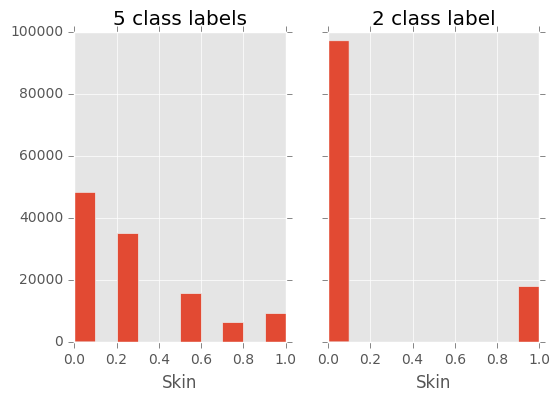

In [124]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(df.skin_discretized_5)
ax1.set_title('5 class labels')
ax1.set_xlabel("Skin") 
ax2.hist(df.skin_discretized_2)
ax2.set_title('2 class label')
ax2.set_xlabel("Skin") 

### Autres features nulles

In [8]:
df.columns[df.isnull().any()]

Index(['height', 'weight', 'position', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp'],
      dtype='object')

In [8]:
df.dropna(inplace=True)

# Analyse
Analyse en différentes parties : df peut se décomposer

### Les joueurs

In [82]:
df['playerShort'].value_counts().describe()

count    1417.000000
mean       81.364150
std        34.635716
min         1.000000
25%        56.000000
50%        77.000000
75%       103.000000
max       202.000000
Name: playerShort, dtype: float64

In [83]:
def identity(x):
    return list(x)[0]    # type(x) = pandas.core.series.Series / players.feature = pandas.core.series

players = df.groupby(df['playerShort'])
players = players.agg({'player': identity, 'club':identity, 'leagueCountry':identity, 'birthday':identity, 
             'height':identity, 'weight':identity, 'position':identity, 
             'games':sum, 'victories':sum, 'ties':sum, 'defeats':sum, 'goals':sum, 
             'yellowCards':sum, 'yellowReds':sum, 'redCards':sum, 'skin':identity})

In [84]:
players.mean()

defeats         76.621736
games          246.880734
weight          76.278052
redCards         1.042343
yellowReds       1.001411
victories      111.571630
yellowCards     32.936486
goals           29.310515
skin             0.282816
ties            58.687368
height         182.170783
dtype: float64

In [91]:
players.leagueCountry.value_counts()

Germany    461
Spain      404
England    323
France     229
Name: leagueCountry, dtype: int64

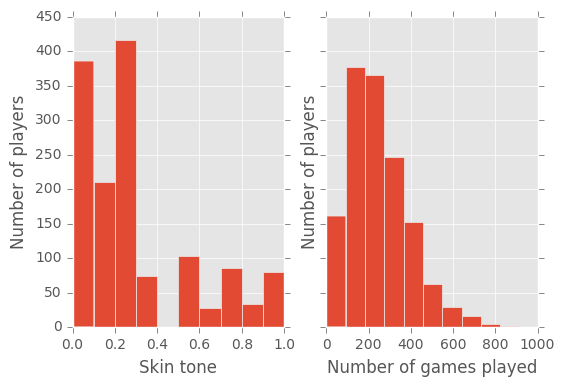

In [90]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.hist(players['skin'])
ax1.set_xlabel("Skin tone") 
ax1.set_ylabel("Number of players")

ax2.hist(players['games'])
ax2.set_xlabel("Number of games played") 
ax2.set_ylabel("Number of players")

### Joueur Arbitre dyads

In [48]:
df[['games','victories', 'ties', 'defeats', 'yellowCards', 'yellowReds', 'redCards']].mean()

games          3.034269
victories      1.371263
ties           0.721293
defeats        0.941714
yellowCards    0.404803
yellowReds     0.012308
redCards       0.012811
dtype: float64

### Les arbitres

In [49]:
df['refNum'].value_counts().describe()

count    2893.000000
mean       39.852402
std        87.977242
min         1.000000
25%         2.000000
50%         8.000000
75%        31.000000
max       770.000000
Name: refNum, dtype: float64

In [50]:
referees = df.groupby(df['refNum'])
referees = referees.agg({'refCountry': identity, 'games':sum, 'goals':sum, 'yellowCards':sum, 'yellowReds':sum, 'redCards':sum})

In [51]:
referees.describe()

,redCards,yellowCards,goals,refCountry,yellowReds,games
count,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000
mean,0.510543,16.132389,14.356377,39.168337,0.490494,120.922917
std,1.927537,58.181324,46.491978,33.301968,1.927363,418.575011
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,8.000000,0.000000,3.000000
50%,0.000000,1.000000,2.000000,32.000000,0.000000,11.000000
75%,0.000000,6.000000,8.000000,57.000000,0.000000,52.000000
max,22.000000,698.000000,519.000000,161.000000,28.000000,5186.000000


- Certains jouent très peu de jeux
- On donne surtout des cartons jaunes

In [52]:
# Nombre total de matchs
sum(referees['games'])

349830

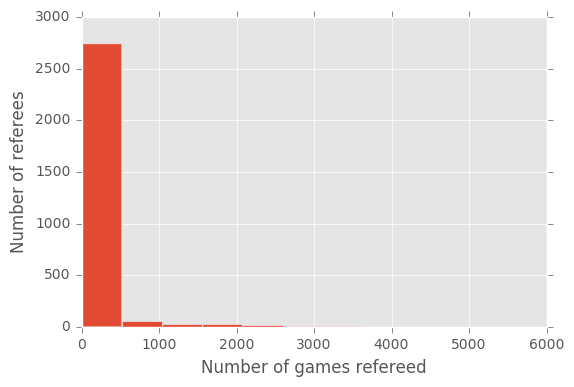

In [53]:
plt.hist(referees['games'])
plt.xlabel("Number of games refereed") 
plt.ylabel("Number of referees")

### Les pays des arbitres

On utilise le tableau des arbitres

In [54]:
referees['refCountry'].value_counts().describe()

count    152.000000
mean      19.032895
std       52.076029
min        1.000000
25%        2.000000
50%        5.500000
75%       19.250000
max      570.000000
Name: refCountry, dtype: float64

Pays plus ou moins peuplés

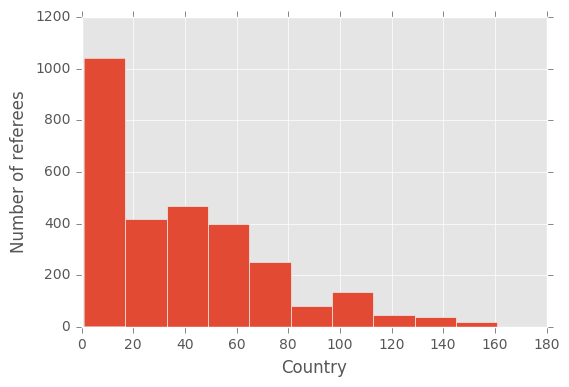

In [55]:
plt.hist(referees['refCountry'])
plt.xlabel("Country") 
plt.ylabel("Number of referees")

In [57]:
refCountry = df[['refCountry','meanIAT','nIAT', 'seIAT', 'meanExp', 'nExp']]
refCountry = refCountry.drop_duplicates()
refCountry.shape

(152, 6)

In [58]:
refCountry.describe()

,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp
count,152.000000,152.000000,1.520000e+02,1.520000e+02,152.000000,1.520000e+02
mean,78.296053,0.305099,1.504561e+04,1.312417e-02,0.291296,1.548661e+04
std,45.475245,0.106170,1.602920e+05,3.252193e-02,0.640170,1.646550e+05
min,1.000000,-0.047254,2.000000e+00,2.235373e-07,-1.375000,2.000000e+00
25%,39.750000,0.262227,3.975000e+01,5.997501e-04,0.022440,4.075000e+01
50%,77.500000,0.340406,1.995000e+02,2.215379e-03,0.395070,2.070000e+02
75%,116.250000,0.371913,6.700000e+02,1.050398e-02,0.638593,7.065000e+02
max,161.000000,0.573793,1.975803e+06,2.862871e-01,1.800000,2.029548e+06


### Feature selection

- Useless / Meaningless features

photoID

In [9]:
df = df.drop('photoID',axis=1)

- Correlated features

In [ ]:
games = victoire + défaite?

In [61]:
df[df['victories']+df['defeats']==df['games']].shape, df.shape

((65750, 31), (115293, 31))

- Feature transformation -> to numerical

Année de naissance, mais pas la date 31.08.1983 ?

In [10]:
df['year'] = df['birthday'].apply(lambda x: int(x.split('.')[2]))

Comme pas ordinal, on ne peut pas transformer string en numerical

## Labels & features

Labels

In [11]:
y = np.asarray(df['skin_discretized_5'], dtype="|S6")

Features

In [12]:
X = df.copy()
X = X.drop(['rater1', 'rater2', 'skin', 'skin_discretized_5', 'skin_discretized_2',
           'playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'position', 'Alpha_3'], axis=1)

Features standardization

In [13]:
def standardize(x):
    """Standardize the original data set."""
    mean_x = np.mean(x)
    x = x - mean_x
    std_x = np.std(x)
    x = x / std_x
    return x

In [14]:
X = standardize(X)

Features correlation with y

In [16]:
y_X = pd.concat([df['skin_discretized_5'],X], axis=1)
corr = y_X.corr()
corr = corr['skin_discretized_5'] # correlation between y and D features
corr = corr.drop('skin_discretized_5')

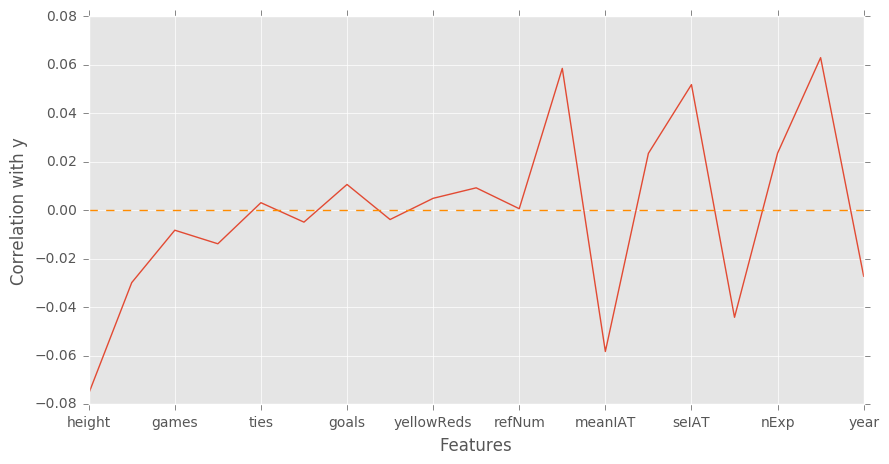

In [52]:
g = corr.plot(figsize =(10,5), x = 'index')
g.axhline(0,color='#FF8C00', linestyle='--')
g.set_xlabel("Features")
g.set_ylabel("Correlation with y") 

Height, refCountry, meanIAT, seIAT, meanExp, seExp sont les var les plus corrélées (0 pas de corrélation / -1 ou 1 : corrélation)

# 1 - Supervised Learning : Random Forests

## Train/test split

In [53]:
# STEP 1: split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=4)

## 1st model

max_depth => reduce bias<br/>
n_estimators => reduce variance

In [55]:
# STEP 2: train the model on the training set
# instantiate the model (using the default parameters)
rfc = RandomForestClassifier(n_jobs=-1)
# fit the model with data
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

n_estimators=10 arbres / max_depth = None

Define function to print accuracy of the model

In [56]:
def print_score(classifier, X_train, y_train, X_test, y_test):
    print('Train set score :', classifier.score(X_train, y_train))
    print('Test set score :', classifier.score(X_test, y_test))

In [58]:
print_score(rfc, X_train, y_train, X_test, y_test)

Train set score : 0.993754969281
Test set score : 0.80723361811


- <b>Influence of parameters</b>

We see that the model is overfitting. We can decrease the overfitting by increasing the number of maximum features

In [66]:
rfc = RandomForestClassifier(max_features=None, n_jobs=-1)
rfc.fit(X_train, y_train)

print_score(rfc, X_train, y_train, X_test, y_test)

Train set score : 0.996241416697
Test set score : 0.955917429203


In [60]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rfc.fit(X_train, y_train)

print_score(rfc, X_train, y_train, X_test, y_test)

Train set score : 0.999392844236
Test set score : 0.851836593087


- <b>Perform cross-validation to mitigate the overfitting of your model. </b>

Cross-validation example: parameter tuning<br>
On choisit max_features plutôt que n_estimator car l'improvement se fait en un temps plus court

In [80]:
max_features_range = list(range(5, 20))
max_features_scores = []
for mf in max_features_range:
    rfc = RandomForestClassifier(max_features=mf, n_jobs=-1)
    scores = cross_val_score(rfc, X, y, cv=3, scoring='accuracy')
    max_features_scores.append(scores.mean())

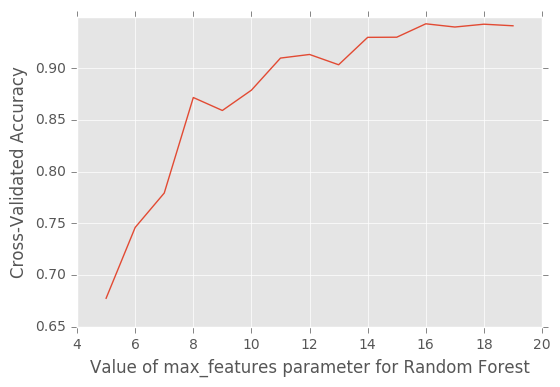

In [81]:
# plot the value of  for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(max_features_range, max_features_scores)
plt.xlabel('Value of max_features parameter for Random Forest')
plt.ylabel('Cross-Validated Accuracy')

In [95]:
range_score = pd.DataFrame(np.c_[max_features_range, max_features_scores], columns = ['max_features', 'score'])
range_score.loc[range_score.score == max(range_score.score)].max_features

11    16.0
Name: max_features, dtype: float64

Let's build this new classifier with max_features = 16

In [110]:
rfc = RandomForestClassifier(max_features=16, n_jobs=-1)
model = rfc.fit(X_train, y_train)

print_score(rfc, X_train, y_train, X_test, y_test)

Train set score : 0.996328153235
Test set score : 0.957305173685


The overfitting is reduced

- <b>Once you assessed your model, inspect the feature\_importances_ attribute and discuss the obtained results. </b>

Starting by defining a function to plot the features importances

In [98]:
def plot_features_importances(ft_imp):
    plt.figure()
    ft_imp.plot(kind='bar')
    
    #plt.title('Feature importance for the trained random forest model')
    plt.xlabel('Feature name', fontweight='bold')
    plt.ylabel('Features importance [%]', fontweight='bold')
    plt.show()

Extract and plot the features importances

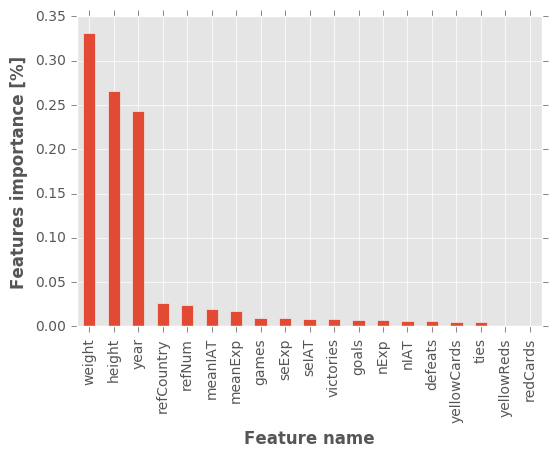

In [111]:
# Extract features importances from model
features_importances = model.feature_importances_

# Create series from features importances and features names
ft_imp = pd.Series(features_importances, index=X.columns.values).sort_values(ascending=False)

# Plot features
plot_features_importances(ft_imp)

yellowReds and redCards are not used<br/>
Three features stands out : 'height', 'weight' and 'year'. We can try to use the first 7 most usefull features to train our random forest classifier<br>
Rappel : On avait obtenu Height, refCountry, meanIAT, seIAT, meanExp, seExp dans les coeffs de corrélation des features à y

- <b>With different assumptions on the data (e.g., dropping certain features even before feeding them to the classifier), can you obtain a substantially different feature\_importances_ attribute?</b>

In [104]:
# number of features choosen
n_features = 7

# extract reduced features set and drop NaN values
X_reduced = df[ft_imp.head(n_features).index].copy()
X_reduced.head(2)

,weight,height,year,refCountry,refNum,meanExp,meanIAT
0,72.0,177.0,1983,1,1,0.396000,0.326391
1,82.0,179.0,1982,2,2,-0.204082,0.203375


We can now train our random forest classifier on the reduced data set

In [113]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reduced, y, test_size=0.4, random_state=4)

rfc_r = RandomForestClassifier(n_jobs=-1)
model_r = rfc_r.fit(X_train_r, y_train_r)

print_score(rfc_r, X_train_r, y_train_r, X_test_r, y_test_r)

Train set score : 0.986584748825
Test set score : 0.895962530899


Not so bad with only 37% for the initial features

Let's see the features importances

In [131]:
# Extract features importances from model
features_importances_reduced = model_r.feature_importances_

# Create series from features importances and features names
ft_imp_r = pd.Series(features_importances_reduced, index=X_reduced.columns.values).sort_values(ascending=False)

# Compare features importance
pd.concat([ft_imp*100, ft_imp_r*100], axis=1, join='inner')

,0,1
weight,33.158038,29.876728
height,26.537459,26.779202
year,24.364290,23.465959
refNum,2.407823,9.883823
meanExp,1.705683,3.535597
refCountry,2.630957,3.378826
meanIAT,1.983698,3.079865


The order of the features importance is similar but :
- The importance of the most significant feature has decreased
- The importance of the less significant features has increased

- <b>BONUS: plot the learning curves against at least 2 different sets of parameters passed to your Random Forest. To obtain smooth curves, partition your data in at least 20 folds. Can you find a set of parameters that leads to high bias, and one which does not?</b>

Bias => Depth

- High Bias (low Train Score) : max_depth = 3

In [149]:
rfc = RandomForestClassifier(max_depth=3, max_features=16, n_estimators=10, n_jobs=-1)

training_sizes=np.array([0.1, 0.325, 0.55, 0.775, 1.]) # set training batch sizes
n_folds = 20 # set n-folds cross validation

# compute learning curve
train_sizes, train_scores, valid_scores = learning_curve(rfc, X, y, train_sizes=training_sizes, cv=n_folds, n_jobs=-1)

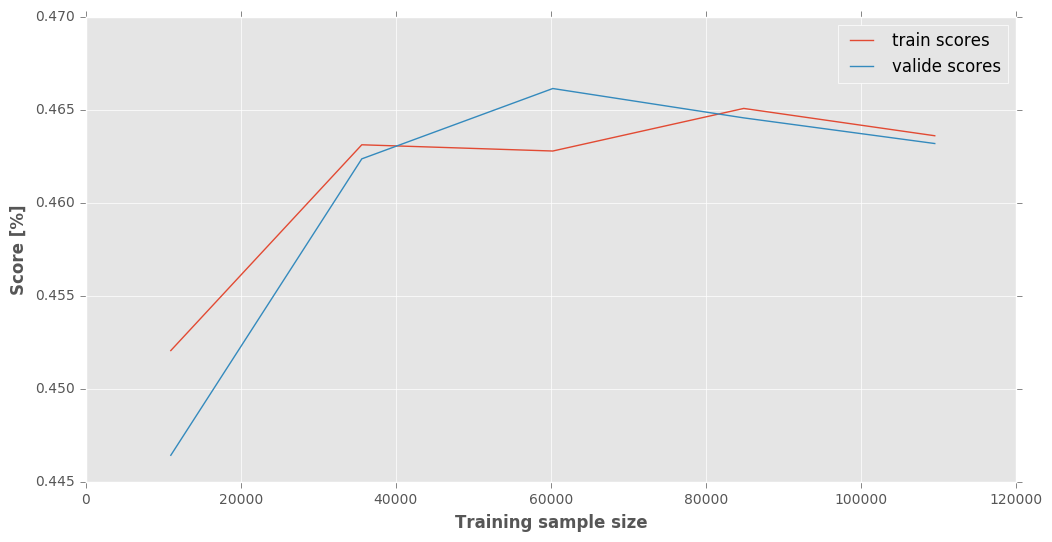

In [156]:
plt.figure(figsize=(12,6))
plt.plot(train_sizes, train_scores.mean(axis=1))
plt.plot(train_sizes, valid_scores.mean(axis=1))
plt.legend(['train scores','valide scores'])
plt.xlabel('Training sample size', fontweight='bold')
plt.ylabel('Score [%]', fontweight='bold')
plt.show()

High Bias => More Data doesn't help

- Small Bias

In [157]:
rfc = RandomForestClassifier(max_depth=150, max_features=16, n_estimators=10, n_jobs=-1)

training_sizes=np.array([0.1, 0.325, 0.55, 0.775, 1.]) # set training batch sizes
n_folds = 20 # set n-folds cross validation

# compute learning curve
train_sizes, train_scores, valid_scores = learning_curve(rfc, X, y, train_sizes=training_sizes, cv=n_folds, n_jobs=-1)

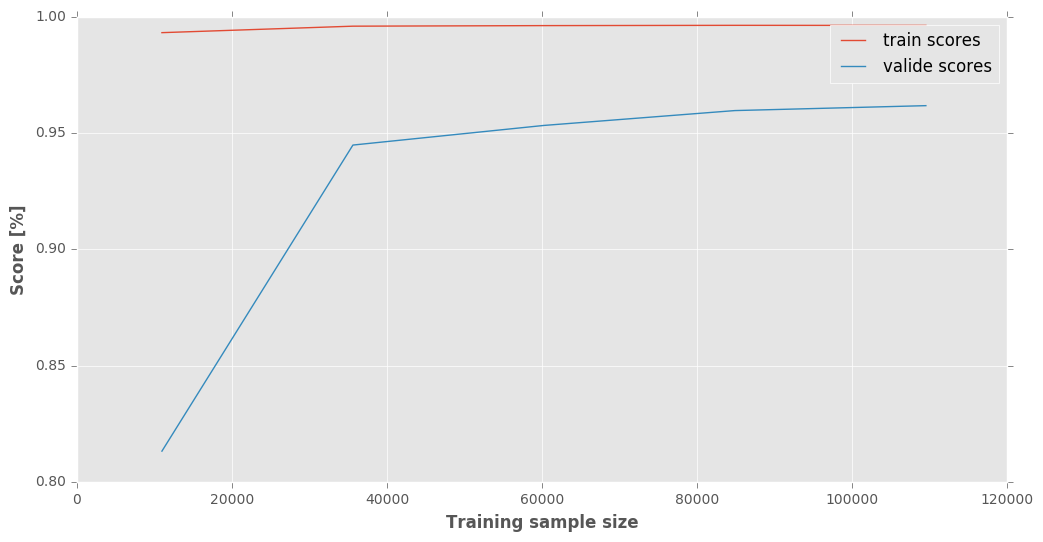

In [158]:
plt.figure(figsize=(12,6))
plt.plot(train_sizes, train_scores.mean(axis=1))
plt.plot(train_sizes, valid_scores.mean(axis=1))
plt.legend(['train scores','valide scores'])
plt.xlabel('Training sample size', fontweight='bold')
plt.ylabel('Score [%]', fontweight='bold')
plt.show()

Smal Bias : More data can help to reduce variance

# 2. Clustering using an unsupervised learning technique

<i>Aggregate the referee information grouping by soccer player, and use an
unsupervised learning technique to cluster the soccer players in 2 disjoint clusters.
Remove features iteratively, and at each step perform again the clustering and
compute the silhouette score -- can you find a configuration of features with high
silhouette score where players with dark and light skin colors belong to different
clusters? Discuss the obtained results.</i>

- Aggregate the referee information grouping by soccer player

In [ ]:
'victories':sum, 'ties':sum, 'defeats':sum, 'goals':sum, 
                              'yellowCards':sum, 'yellowReds':sum, 'redCards':sum,

In [254]:
def mean(x):
    return np.mean(x)

players_df = df.groupby(df['playerShort'])
# take only numerical features
players_df = players_df.agg({'height':identity, 'weight':identity, 'skin':identity, 'year':identity,
                              'games':sum, 'victories':sum, 'ties':sum, 'defeats':sum, 'goals':sum, 
                              'yellowCards':sum, 'yellowReds':sum, 'redCards':sum,
                              'meanIAT': mean, 'nIAT': mean, 'seIAT': mean, 
                              'meanExp': mean, 'nExp': mean, 'seExp': mean
                             })

Le nombre de cartons, buts, victoires... est proportionnel au nombre de matchs joués. On divise donc ces features par le nombre de matchs :

In [261]:
for feature in ['victories', 'ties', 'defeats', 'goals', 'yellowCards', 'yellowReds', 'redCards']:
    players_df[feature] = players_df[feature] / players_df.games

Standardization

In [262]:
players_df = standardize(players_df)
players_df.head(2)

,yellowReds,victories,meanExp,height,ties,redCards,seExp,goals,skin,meanIAT,yellowCards,weight,nExp,defeats,games,seIAT,nIAT,year
playerShort,,,,,,,,,,,,,,,,,,
aaron-hughes,-0.690829,-0.582505,0.309252,-0.025119,0.751504,-0.728126,0.291169,-0.816500,-0.549349,-0.188539,-1.378934,-0.743505,0.149509,0.251795,2.881194,0.059161,0.141324,-1.519347
aaron-hunt,-0.690829,-0.147926,-0.179684,0.121964,-0.445040,-0.231371,-0.416213,0.680839,-0.549349,-0.004801,-0.137526,-0.461770,0.374394,0.426934,0.630699,-0.395373,0.379086,0.084911


Let's try a k-means clustering on the training data, K = 2

In [263]:
kmeans_model = KMeans(n_clusters=2)
clust_model = kmeans_model.fit(players_df)
score = silhouette_score(players_df, clust_model.predict(players_df))
score

0.10155857619029483

Really low score

- Remove features iteratively, and at each step perform again the clustering and
compute the silhouette score = = Feature selection = Ablation

A chaque itération, on retire la feature sans laquelle on obtient le plus grand score. (Cross Validation)<br>
Tant que le score s'améliore, on continue.

In [251]:
def find_feature_to_delete(X):
    
    nb_features = X.shape[1]
    scores = np.zeros(nb_features)
    
    for nb_f in list(range(nb_features)):
        
        x_del = X.drop(X.columns[nb_f], axis=1)
        kmeans_model = KMeans(n_clusters=2)
        clust_model = kmeans_model.fit(x_del)
        
        scores[nb_f]=silhouette_score(x_del, clust_model.predict(x_del))
    
    return X.columns[np.argmax(scores)], np.max(scores)

In [264]:
old_score = 0  
# init : score = 0.219
players_df_reduced = players_df.copy()

print("Initial Score : ", score)

while (players_df_reduced.shape[1] > 1):
    old_score = score
    feature, score = find_feature_to_delete(players_df_reduced)
    if (score > old_score):
        print("Deleted feature = ", feature, " \t \t Score = ", score)
        players_df_reduced = players_df_reduced.drop(feature, axis=1)
    else :
        break

Initial Score :  0.10155857619
Deleted feature =  meanIAT  	 	 Score =  0.131160573683
Deleted feature =  yellowReds  	 	 Score =  0.142335770521
Deleted feature =  redCards  	 	 Score =  0.154998168103
Deleted feature =  meanExp  	 	 Score =  0.16834336149
Deleted feature =  yellowCards  	 	 Score =  0.18141161893
Deleted feature =  year  	 	 Score =  0.199335294312
Deleted feature =  defeats  	 	 Score =  0.381301964952
Deleted feature =  goals  	 	 Score =  0.411091794097
Deleted feature =  height  	 	 Score =  0.434902465494
Deleted feature =  weight  	 	 Score =  0.500348979003
Deleted feature =  games  	 	 Score =  0.542958997464
Deleted feature =  seExp  	 	 Score =  0.789027721972


In [266]:
players_df_reduced.shape[1], players_df_reduced.columns

(6,
 Index(['victories', 'ties', 'skin', 'nExp', 'seIAT', 'nIAT'], dtype='object'))

0.712623145895


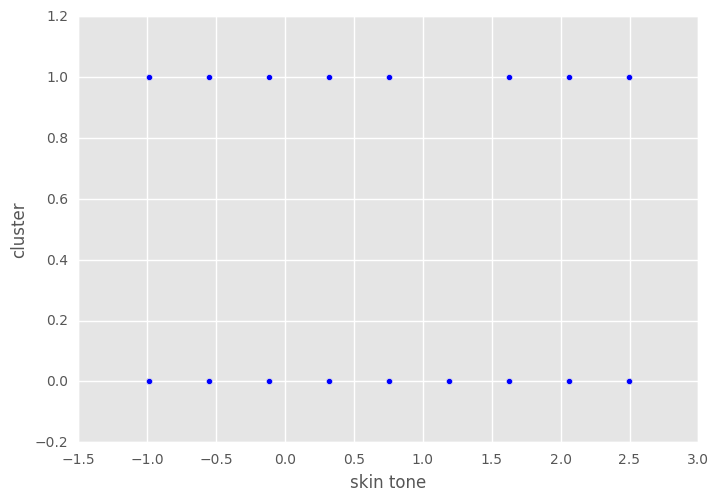

In [280]:
kmeans_model = KMeans(n_clusters=2)
clust_model = kmeans_model.fit(players_df_reduced)
y_pred = clust_model.predict(players_df_reduced)
score = silhouette_score(players_df_reduced, y_pred)
print(score)

plt.scatter(players_df_reduced['skin'], y_pred)
plt.xlabel('skin tone')
plt.ylabel('cluster')

Le cluster choisi semble relativement indépendant de la couleur de la peau puisqu'elle est répartie de façons égale dans chaque cluster.

Quel était le score de la peau seule?

In [305]:
skin=players_df[['skin']]
kmeans_model = KMeans(n_clusters=2)
clust_model = kmeans_model.fit(skin)
score=silhouette_score(skin, clust_model.predict(skin))
score

0.715866997442967

L'ablation ne nous assure pas de trouver la meilleure combinaison de features possible.<br/>
Nous qui cherchons à classifier en fonction de la couleur de peau, pourquoi ne pas partir de là et ajouter progressivement des features? (Wrapper)

In [304]:
def find_feature_to_add(X, features):
    
    scores = np.zeros(X.shape[1])
    
    for nb_f in list(range(X.shape[1])):
        if not (X.columns[nb_f] in features):
            
            features.append(X.columns[nb_f])
            kmeans_model = KMeans(n_clusters=2)
            clust_model = kmeans_model.fit(X[features])
            scores[nb_f]=silhouette_score(X[features], clust_model.predict(X[features]))
            print(scores[nb_f])
            features.remove(X.columns[nb_f])
    
    return X.columns[np.argmax(scores)], np.max(scores)

In [306]:
old_score = 0  
# init : score = 0.71586
features = ['skin']
players_df_reduced = players_df.copy()

print("Initial Score : ", score)

while (len(features) < players_df.shape[1]):
    old_score = score
    feature, score = find_feature_to_add(players_df, features)
    if (score > old_score):
        print("Added feature = ", feature, " \t \t Score = ", score)
        features.append(feature)
    else :
        break

Initial Score :  0.715866997443
0.489186851214
0.453984196956
0.46267694973
0.432629425748
0.468856735337
0.486752141745
0.61746460624
0.467455763795
0.477619440085
0.446115230077
0.440237723465
0.569282613263
0.463432873106
0.442664792906
0.623834369411
0.570075324524
0.430336905308


Il ne parvient pas à trouver de feature capable d'améliorer le score<br/>
Certaines données sont liées et ne permettent une amélioration du score qu'à partir du moment ou on les rassemble